##### Modeling: Predict total_sales

- To load the data from end of EDA process, and to compare the results by traditional machining (RandomForest) and MLP

- Save the model

In [1]:
# load the data 
import pandas as pd
df = pd.read_csv('df_with_sentiment.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6208 entries, 0 to 6207
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             6208 non-null   int64  
 1   title                  6208 non-null   object 
 2   platform               6208 non-null   object 
 3   releaseDate            6208 non-null   object 
 4   rating                 6208 non-null   object 
 5   genres                 6208 non-null   object 
 6   quote                  6208 non-null   object 
 7   score                  6208 non-null   float64
 8   total_sales            6208 non-null   float64
 9   original_price         6208 non-null   float64
 10  release_year           6208 non-null   int64  
 11  release_quarter        6208 non-null   int64  
 12  release_month          6208 non-null   int64  
 13  processed_tokens       6208 non-null   object 
 14  clean_text_stemmed     6184 non-null   object 
 15  clea

##### There are a few models will be run:
1) Simple Linear Regression
2) Random Foreast 
3) Random Foreast (with adjusted parameters)
4) MLP

In [2]:
#Simple Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer



# Choose X, y coulmns
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'processed_tokens',
              'clean_text_stemmed', 'clean_text_lemmatized', 'entities', 'frequency', 
              'sentiment'], axis=1, errors='ignore')
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

y = df['total_sales']



print(X.shape)
# Impute Missing value for X??
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Spilt data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Modeling : LinearRegression
model = LinearRegression()

# RMSE definition : --> cross_ val_score does not have RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Cross_validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# fit the model
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test)




print(f"Model 0: LinearRegression")

print(f"Cross-Validation RMSE scores in training set: {cv_scores}")
print("Mean RMSE in training set:", cv_scores.mean())
print("RMSE in testing set:", mean_squared_error(y_test, y_pred, squared=False))



print("Cross-validated R² scores in training set:", cv_r2_scores)
print("Mean R² score in training set:", cv_r2_scores.mean())
print("R² score in testing set:", r2_score(y_test, model.predict(X_test)))


(6208, 50)
Model 0: LinearRegression
Cross-Validation RMSE scores in training set: [0.2060043  0.20534283 0.21639199 0.19665416 0.20953165]
Mean RMSE in training set: 0.20678498817322638
RMSE in testing set: 0.2093372811193088
Cross-validated R² scores in training set: [0.6225784  0.62933147 0.61919276 0.63504006 0.6238566 ]
Mean R² score in training set: 0.6259998586100709
R² score in testing set: 0.6351829253027443


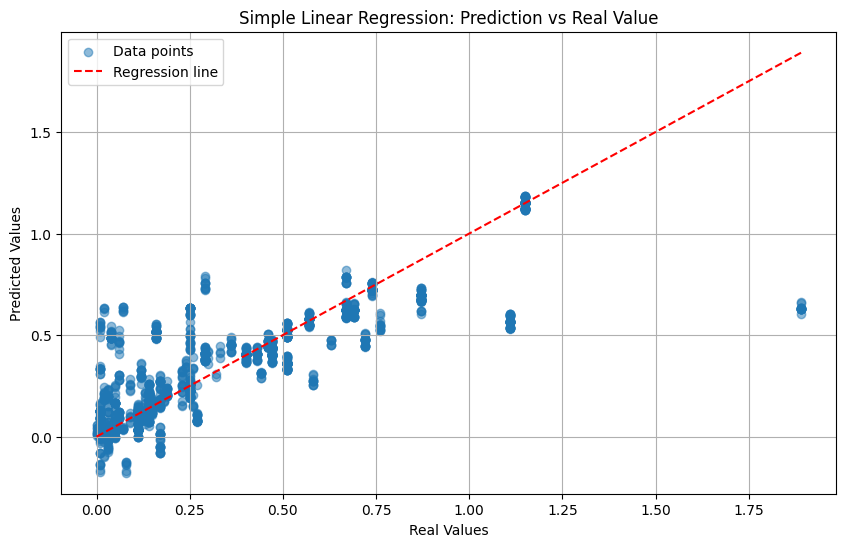

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Data points')

# 绘制线性回归线
#plt.plot(y_test, slope * y_test + intercept, color='red', label='Regression line')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label='Regression line')
plt.grid(True)

# 添加标签和标题
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Simple Linear Regression: Prediction vs Real Value')
plt.legend()

plt.show()


In [4]:
'''
#2. Random Foreast and log-transformed 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# 轉換 log
import numpy as np
df['log_total_sales'] = np.log1p(df['total_sales'])  # log1p(x) = log(1 + x)


# Choose X, y coulmns
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'processed_tokens',
              'clean_text_stemmed', 'clean_text_lemmatized', 'entities', 'frequency', 
              'sentiment', 'log_total_sales'], axis=1, errors='ignore')
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

y = df['log_total_sales'] 

print(X.shape)
# Impute Missing value for X??
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Spilt data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Modeling : RandomForest
model = RandomForestRegressor(random_state=42)

# RMSE definition : --> cross_ val_score does not have RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Cross_validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)
# Cross-validation with R² scoring
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# fit the model
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # 將 log 還原回原始銷售值
y_test_original = np.expm1(y_test)  # 把 y_test 也還原以便計算 RMSE

# Step 10: 評估
print(f"\nModel1.1: RandomForestRegressor (log-transformed target)")
print(f"Cross-Validation RMSE scores: {cv_scores}")
print("Test RMSE:", mean_squared_error(y_test_original, y_pred, squared=False))



# Print the R² scores
print("Cross-validated R² scores:", cv_r2_scores)
print("Mean R² score:", cv_r2_scores.mean())
'''

'\n#2. Randon Foreast and log-transformed \nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import make_scorer, mean_squared_error\n\n# 轉換 log\nimport numpy as np\ndf[\'log_total_sales\'] = np.log1p(df[\'total_sales\'])  # log1p(x) = log(1 + x)\n\n\n# Choose X, y coulmns\nX = df.drop([\'Unnamed: 0\',\'title\', \'quote\', \'releaseDate\', \'total_sales\', \'processed_tokens\',\n              \'clean_text_stemmed\', \'clean_text_lemmatized\', \'entities\', \'frequency\', \n              \'sentiment\', \'log_total_sales\'], axis=1, errors=\'ignore\')\nX = pd.get_dummies(X, columns=[\'platform\', \'rating\', \'genres\', \'predicted_sentiment\'], drop_first=True)\n\ny = df[\'log_total_sales\'] \n\nprint(X.shape)\n# Impute Missing value for X??\nimputer = SimpleIm

In [5]:
# RandomForestRegressor (Orginal y)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Orginal y 
y = df['total_sales']

# Choose X
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'log_total_sales',
             'processed_tokens', 'clean_text_stemmed', 'clean_text_lemmatized',
             'entities', 'frequency', 'sentiment'], axis=1, errors='ignore')

# 
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

print("X shape:", X.shape)

# Imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Model definition
model = RandomForestRegressor(random_state=42)

# Cross-validation: RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)

# Cross-validation: R²
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# fit the mode
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Model evaluation
print(f"\nModel2: RandomForestRegressor (original target)")
print(f"Cross-Validation RMSE scores in training set: {cv_scores}")
print("Mean RMSE in training set:", cv_scores.mean())
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("-----------------------------------------------")
print("Cross-validated R² scores:", cv_r2_scores)
print("Mean R² score in training set:", cv_r2_scores.mean())
print("R² score in testing set:", r2_score(y_test, model.predict(X_test)))



X shape: (6208, 50)

Model2: RandomForestRegressor (original target)
Cross-Validation RMSE scores in training set: [0.00147852 0.00065642 0.00245306 0.00211774 0.00325259]
Mean RMSE in training set: 0.001991665936211621
Test RMSE: 0.0008197901096865468
-----------------------------------------------
Cross-validated R² scores: [0.99998056 0.99999621 0.99995106 0.99995768 0.99990936]
Mean R² score in training set: 0.9999589742524714
R² score in testing set: 0.9999944051641748


In [6]:
# RandomForestRegressor (Orginal y)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV

# 不做 log 轉換，直接使用原始 total_sales
y = df['total_sales']

# 選擇 X 特徵
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'log_total_sales',
             'processed_tokens', 'clean_text_stemmed', 'clean_text_lemmatized',
             'entities', 'frequency', 'sentiment'], axis=1, errors='ignore')

# 類別變數轉換
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

print("X shape:", X.shape)

# 補缺值
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [10,15 ],
    'min_samples_split': [ 2,5],
    'min_samples_leaf': [1,5],
    'max_features': ['log2']
}

# 模型定義
rf = RandomForestRegressor(random_state=42)
print( "Model3: RandomForestRegressor")
# 定義 RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# 設定 GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                       # 5-fold cross validation
    scoring=rmse_scorer,        # 使用 RMSE 當作評估標準
    n_jobs=-1,                  # 平行處理所有核心
    verbose=0                   # 印出訓練過程
)
grid_search.fit(X_train, y_train)

print("Best RMSE Score in training set:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 获取交叉验证结果
cv_results = grid_search.cv_results_

# 打印每个参数组合及其得分
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Parameters: %s" % params)
    print("Mean RMSE in training set: %0.4f" % mean_score)
    


print("-----------------------------------------------")
# 使用最佳参数重新預測
best_rf = grid_search.best_estimator_
print('best_rf:',best_rf)
# 在测试集上进行预测
y_pred = best_rf.predict(X_test)


RMSE_test = mean_squared_error(y_test, best_rf.predict(X_test), squared=False)
print("RMSE in testing set:", RMSE_test)


cv_r2_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
# 计算并打印 R² 分数
print("Mean R² score in training set:", cv_r2_scores.mean())
# test dataset for R2 score
print("R² score in testing set:", r2_score(y_test, best_rf.predict(X_test)))

X shape: (6208, 50)
Model3: RandomForestRegressor
Best RMSE Score in training set: 0.14216312387398428
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean RMSE in training set: 0.1198
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean RMSE in training set: 0.1159
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean RMSE in training set: 0.1221
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean RMSE in training set: 0.1189
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Mean RMSE in training se

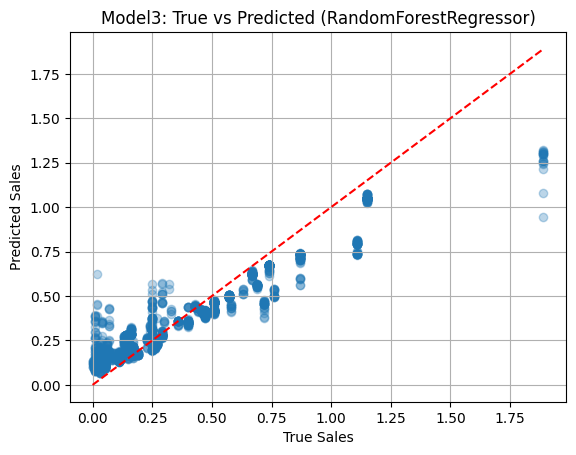

In [7]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title('Model3: True vs Predicted (RandomForestRegressor)')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()


In [ ]:
# Test: Save the model

"""
import joblib
# Save model, imputer, and model features
joblib.dump(model, 'Model/rf_model.pkl')
joblib.dump(imputer, 'Model/imputer.pkl')
joblib.dump(X.columns.to_list(), 'Model/model_features.pkl')
print('Finish :save models!')
"""


import joblib
# Save model, imputer, and model features
joblib.dump(best_rf, 'Model/rf_model.pkl') #best model of random foreast
joblib.dump(imputer, 'Model/imputer.pkl')
joblib.dump(X.columns.to_list(), 'Model/model_features.pkl')
print('Finish :save models!')


# Keras
#model.save('model.h5')
#model = keras.models.load_model('model.h5')


Finish :save models!


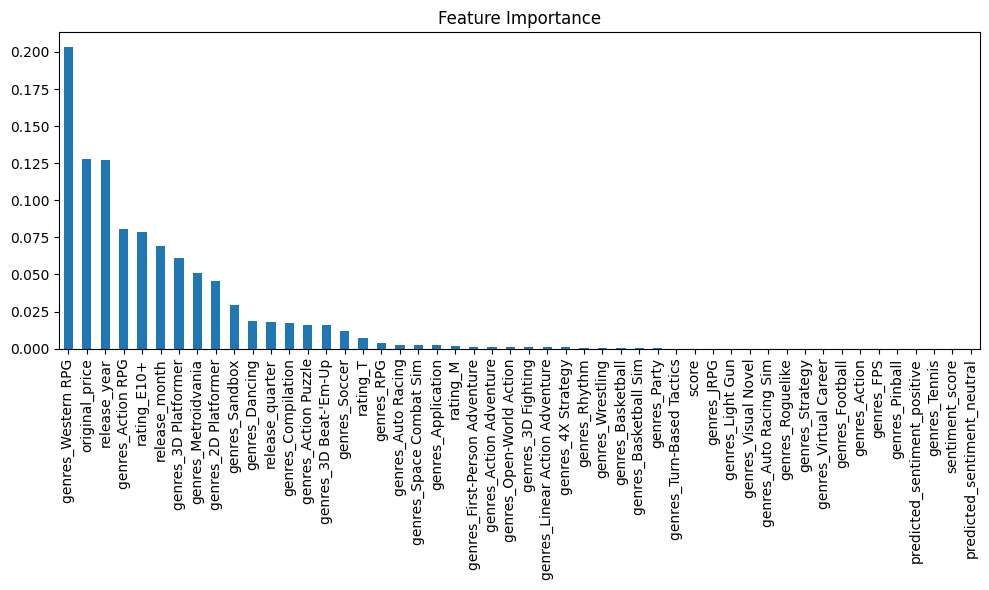

In [9]:
# Feature Importance 

importances = model.feature_importances_
feature_names = X_test.columns


import pandas as pd
import matplotlib.pyplot as plt

# top8 feature
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(10, 6), title='Feature Importance')
plt.tight_layout()
plt.show()


In [10]:
# model2 : MLP

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# grid search by using different hyper-paramenter
from itertools import product

# Hyper Paramenter setting
architectures = [(64,), (100, 50)]
learning_rates = [0.001, 0.01]
alphas = [0.0001, 0.001, 0.01, 0.1]  # add L2 regularization
activations = ['relu', 'tanh']

# 用 itertools.product grid 
param_grid = [
    {'arch': arch, 'lr': lr, 'alpha': alpha, 'act': act}
    for arch, lr, alpha, act in product(architectures, learning_rates, alphas, activations)
]



results = []


for params in param_grid:
    # Create Models
    model = MLPRegressor(
            hidden_layer_sizes=params['arch'],
            activation=params['act'],
            solver='adam',
            learning_rate_init=params['lr'],
            alpha=params['alpha'],
            max_iter=1000,
            early_stopping=True,
            random_state=42
        )

   # CV RMSE
    cv_rmse = cross_val_score(model, X_train, y_train, cv=5,
                              scoring=make_scorer(mean_squared_error, squared=False)).mean()

    #training and testing
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)

    # Print Result
    results.append({
        'Architecture': str(params['arch']),
        'Learning Rate': params['lr'],
        'Alpha': params['alpha'],
        'Activation': params['act'],
        'CV RMSE': round(cv_rmse, 4),
        'Test RMSE': round(test_rmse, 4),
        'Train R²': round(train_r2, 4),
        'Test R²': round(test_r2, 4)
    })

# Print it as a table 
results_df = pd.DataFrame(results).sort_values(by='Test R²')
display(results_df)

,Architecture,Learning Rate,Alpha,Activation,CV RMSE,Test RMSE,Train R²,Test R²
14,"(64,)",0.010,0.1000,relu,0.0826,0.1043,0.9111,0.9095
31,"(100, 50)",0.010,0.1000,tanh,0.0586,0.0650,0.9655,0.9649
18,"(100, 50)",0.001,0.0010,relu,0.0557,0.0559,0.9863,0.9739
7,"(64,)",0.001,0.1000,tanh,0.0558,0.0532,0.9774,0.9764
6,"(64,)",0.001,0.1000,relu,0.0513,0.0505,0.9817,0.9787
15,"(64,)",0.010,0.1000,tanh,0.0632,0.0491,0.9815,0.9800
20,"(100, 50)",0.001,0.0100,relu,0.0519,0.0484,0.9933,0.9805
0,"(64,)",0.001,0.0001,relu,0.0615,0.0440,0.9929,0.9839
16,"(100, 50)",0.001,0.0001,relu,0.0558,0.0434,0.9953,0.9843
23,"(100, 50)",0.001,0.1000,tanh,0.0415,0.0425,0.9853,0.9850


According to the result of NLP models, the test set R2 are around 0.90 ~0.99.
